In [111]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import re
import requests
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

In [100]:
with open('coffee_words.pickle','rb') as read_file:
    coffee = pickle.load(read_file)
with open('coffee_ratings.pickle','rb') as read_file:
    ratings = pickle.load(read_file)
with open('combined.pickle','rb') as read_file:
    combined = pickle.load(read_file)
with open('df.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [83]:
combined.head()

,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
0,Jackrabbit Java,Costa Rica,Medium-Light,1,93,9.0,9.0,9.0,8.0,8.0
1,Jackrabbit Java,"Nyamasheke District, Rwanda",Medium-Light,0,92,9.0,8.0,9.0,8.0,8.0
2,Red Rooster Coffee Roaster,"Los Naranjos, La Argentina, Huila Department, ...",Light,0,96,9.0,9.0,10.0,9.0,9.0
3,Paradise Roasters,"Huila, Colombia",Light,0,95,9.0,9.0,9.0,9.0,9.0
4,Kakalove Cafe,"Antioquia Department, Colombia",Medium-Light,1,95,9.0,9.0,9.0,9.0,9.0


In [84]:
combined.loc[(combined.aroma == 'NR')|(combined.aroma == 'NA'),'aroma'] = '-999'
combined.aroma = combined.aroma.astype(float)
combined.aroma = combined.aroma.round(0)

combined.loc[(combined.body == 'NR')|(combined.body == 'NA'),'body'] = '-999'
combined.body = combined.body.astype(float)
combined.body = combined.body.round(0)

combined.loc[(combined.flavor == 'NR')|(combined.flavor == 'NA'),'flavor'] = '-999'
combined.flavor = combined.flavor.astype(float)
combined.flavor = combined.flavor.round(0)

combined.aftertaste.fillna('-999',inplace=True)
combined.aftertaste = combined.aftertaste.astype(float)
combined.aftertaste = combined.aftertaste.round(0)

combined.loc[(combined.acidity == 'NR')|(combined.acidity == 'NA')|(combined.acidity == 'na')|(combined.acidity == 'n/a'),'acidity'] = '-999'
combined.loc[(combined.acidity == 'Very Low'),'acidity'] = '1'
combined.loc[(combined.acidity == 'Low'),'acidity'] = '3'
combined.loc[(combined.acidity == 'Moderate'),'acidity'] = '5'
combined.acidity.fillna(-999,inplace=True)
combined.acidity = combined.acidity.astype(float)
combined.acidity = combined.acidity.round(0)

combined.dropna(subset=['rating','aroma','body','flavor','aftertaste','acidity'],axis=0,inplace=True)
# pd.get_dummies(combined,columns=['group'])
combined.head()

C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
0,Jackrabbit Java,Costa Rica,Medium-Light,1,93,9.0,9.0,9.0,8.0,8.0
1,Jackrabbit Java,"Nyamasheke District, Rwanda",Medium-Light,0,92,9.0,8.0,9.0,8.0,8.0
2,Red Rooster Coffee Roaster,"Los Naranjos, La Argentina, Huila Department, ...",Light,0,96,9.0,9.0,10.0,9.0,9.0
3,Paradise Roasters,"Huila, Colombia",Light,0,95,9.0,9.0,9.0,9.0,9.0
4,Kakalove Cafe,"Antioquia Department, Colombia",Medium-Light,1,95,9.0,9.0,9.0,9.0,9.0


In [90]:
combined_onehot = pd.get_dummies(combined,columns=['group'])

In [116]:
features = ['aroma','body','flavor','aftertaste','acidity','group_0','group_1','group_2']
useful = combined_onehot[(combined_onehot.rating>0)&(combined_onehot.aroma>0)&(combined_onehot.body>0)&(combined_onehot.flavor>0)&(combined_onehot.aftertaste>0)&(combined_onehot.acidity>0)]
_X, X_, _y, y_ = train_test_split(useful[features],useful.rating,test_size=.2,random_state=42)

In [28]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [117]:
train_X, train_y = np.array(_X), np.array(_y)
#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

test_set_pred = lm.predict(X_)

mae_kfoldlinear = mae(y_,test_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldlinear)

Simple regression scores:  [0.943, 0.934, 0.96, 0.944, 0.934] 

Simple mean cv r^2: 0.943 +- 0.010 

The average error (MAE) on a predicted value on the holdout test data is:  0.3625383332786083


In [93]:
list(zip(_X.columns, lm.coef_))

[('aroma', 1.0359986873404616),
 ('body', 0.7653816767494112),
 ('flavor', 1.0184655020317293),
 ('aftertaste', 1.1468955493279112),
 ('acidity', 0.9079070385453952),
 ('group_0', -0.10563516216031248),
 ('group_1', 0.07314880565658714),
 ('group_2', 0.03248635650372536)]

In [119]:
alphavec = 10**np.linspace(-2,2,200)
std = StandardScaler()
std.fit(_X)
num_X = std.transform(_X)

lasso =  LassoCV(alphas = alphavec, cv = 5)
lasso.fit(num_X,_y)
list(zip(_X.columns, lasso.coef_))

[('aroma', 0.7728056983537832),
 ('body', 0.49629369461559064),
 ('flavor', 0.8004775620185144),
 ('aftertaste', 0.8475181644559082),
 ('acidity', 0.7257279348409318),
 ('group_0', -0.051336804749588225),
 ('group_1', 0.01865979062187644),
 ('group_2', 0.0)]

In [121]:
test_lasso_pred = lasso.predict(std.transform(X_))
mae_lasso = mae(y_,test_lasso_pred)
print('The r^2 on a predicted value is: ',r2_score(y_, test_lasso_pred))
print('The average error (MAE) on a predicted value is: ',mae_lasso)

The r^2 on a predicted value is:  0.9445234823759198
The average error (MAE) on a predicted value is:  0.36739740346346983


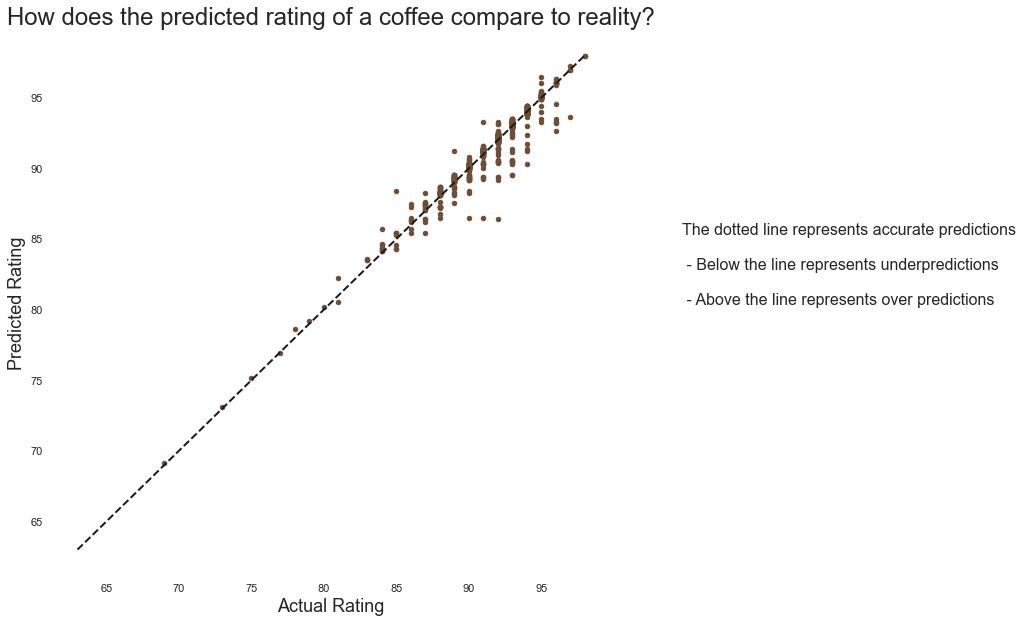

In [94]:
y = useful.rating
sns.set(rc={'figure.figsize':(10, 10)})
fig, ax = plt.subplots()
ax.scatter(y_, test_set_pred, s=20,color='#6f4e37')
ax.set_facecolor('white')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Actual Rating',fontsize=18)
ax.set_ylabel('Predicted Rating',fontsize=18)
ax.set_title('How does the predicted rating of a coffee compare to reality?',fontsize=24)
txt = 'The dotted line represents accurate predictions' + '\n \n'+' - Below the line represents underpredictions' + '\n\n'+ ' - Above the line represents over predictions'
text = fig.text(1,.5,txt,fontsize=16)
# fig.savefig('OneDrive\Desktop\Metis\Projects\Project 2\wridge_actualvspredicted',kind='png')
plt.show()



In [95]:
errors = pd.concat([pd.DataFrame(y_),pd.DataFrame(X_)],axis=1)
errors['preds'] = lm.predict(errors[features])
errors['error'] = np.absolute(errors.rating-errors.preds)
errors.sort_values(by='error',ascending=False).head(10)

,rating,aroma,body,flavor,aftertaste,acidity,group_0,group_1,group_2,preds,error
4022,92,7.0,7.0,8.0,7.0,7.0,0,0,1,86.428235,5.571765
4929,91,7.0,7.0,8.0,7.0,7.0,0,1,0,86.468897,4.531103
4619,94,8.0,8.0,8.0,8.0,8.0,0,1,0,90.325080,3.674920
4909,90,8.0,7.0,7.0,7.0,7.0,0,1,0,86.486430,3.513570
4362,93,8.0,7.0,8.0,8.0,8.0,0,0,1,89.519036,3.480964
4393,93,8.0,7.0,8.0,8.0,8.0,0,1,0,89.559698,3.440302
4359,97,10.0,7.0,10.0,8.0,8.0,0,0,1,93.627964,3.372036
4496,96,9.0,7.0,10.0,8.0,8.0,0,1,0,92.632628,3.367372
4761,85,9.0,7.0,8.0,7.0,7.0,1,0,0,88.362111,3.362111
4415,92,8.0,8.0,8.0,7.0,8.0,0,1,0,89.178185,2.821815


In [98]:
combined.loc[[4022,4929,4619,4909,4393,4496,4761,4362,4359,4415]]

,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
4022,Green Mountain Coffee,South-central Kenya,Medium-Dark,2,92,7.0,7.0,8.0,7.0,7.0
4929,Iron Brew Coffee,"Cerrado growing region, Minas Gerais State, Br...",Medium-Light,1,91,7.0,7.0,8.0,7.0,7.0
4619,Atomic Cafe Coffee Roasters,"Narino Department, southern Colombia",Medium,1,94,8.0,8.0,8.0,8.0,8.0
4909,The Roasterie,Colombia,Medium,1,90,8.0,7.0,7.0,7.0,7.0
4393,Klatch Coffee,"Huila Department, Colombia.",Medium-Light,1,93,8.0,7.0,8.0,8.0,8.0
4496,Paradise Roasters,"Boquete growing region, western Panama",Medium,1,96,9.0,7.0,10.0,8.0,8.0
4761,Supreme Bean Coffee Roasters,"Kaanapali district, near Lahaina, West Maui, H...",Medium-Light,0,85,9.0,7.0,8.0,7.0,7.0
4362,Green Mountain Coffee,"Yirgacheffe growing region, Sidamo Province, s...",Medium,2,93,8.0,7.0,8.0,8.0,8.0
4359,Terroir Coffee,South-central Kenya.,Medium,2,97,10.0,7.0,10.0,8.0,8.0
4415,PT's Coffee Roasting Co.,Rwanda.,Medium,1,92,8.0,8.0,8.0,7.0,8.0


In [101]:
df.head()

,Roaster,Text,Two Topic,Three Topic,Four Topic,Five Topic,Six Topic,Seven Topic,Eight Topic,Ten Topic,Nine Topic,rating
0,Jackrabbit Java,"Yeasty, richly sweet-savory. Fresh-baked bread...",1,1,1,1,1,1,1,1,1,93
1,Jackrabbit Java,"Balanced, sweet-toned, floral. Tea rose, cocoa...",0,0,3,0,0,3,7,5,5,92
2,Red Rooster Coffee Roaster,"Delicate, deep; complex. Pomegranate, macadami...",0,0,3,3,3,3,3,5,5,96
3,Paradise Roasters,"Very sweet, floral-toned. Freesia, pink grapef...",0,0,3,3,3,3,3,5,5,95
4,Kakalove Cafe,"Opulent, richly sweet-tart-savory. Black curra...",0,1,3,4,4,3,3,5,5,95


In [104]:
one_hot = pd.get_dummies(df,columns=['Two Topic','Three Topic','Four Topic','Five Topic','Six Topic','Seven Topic','Eight Topic','Nine Topic','Ten Topic'])
one_hot = one_hot[one_hot.rating>0]

In [126]:
_X, X_, _y, y_ = train_test_split(one_hot.drop(columns=['Roaster','Text','rating']),one_hot.rating,test_size=.2,random_state=42)

In [135]:
train_X, train_y = np.array(_X), np.array(_y)
#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lmwords = LinearRegression()

    lmwords.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lmwords.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

word_set_pred = lmwords.predict(X_)

mae_kfoldwords = mae(y_,word_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldwords)

alphavec = 10**np.linspace(-2,2,200)
std_words= StandardScaler()
std_words.fit(_X)
X_words = std_words.transform(_X)

lasso_words =  LassoCV(alphas = alphavec, cv = 5)
lasso_words.fit(X_words,_y)
word_lasso_pred = lasso_words.predict(std_words.transform(X_))
list(zip(_X.columns, lasso_words.coef_))


Simple regression scores:  [0.246, 0.265, 0.291, 0.285, 0.253] 

Simple mean cv r^2: 0.268 +- 0.018 

The average error (MAE) on a predicted value on the holdout test data is:  2.719531413990344


[('Two Topic_0', 0.5140477122150904),
 ('Two Topic_1', -0.0),
 ('Three Topic_0', -0.0),
 ('Three Topic_1', 0.0640247909443561),
 ('Three Topic_2', -0.2776935253460187),
 ('Four Topic_0', 0.006912757950952578),
 ('Four Topic_1', -0.06933296799158246),
 ('Four Topic_2', 0.07306618932624573),
 ('Four Topic_3', -0.0),
 ('Five Topic_0', 0.0),
 ('Five Topic_1', -0.46373166369515545),
 ('Five Topic_2', -0.11739952805809296),
 ('Five Topic_3', 0.4411901336077375),
 ('Five Topic_4', 0.0),
 ('Six Topic_0', 0.013581674626825524),
 ('Six Topic_1', -0.0),
 ('Six Topic_2', -0.6722797244927596),
 ('Six Topic_3', 0.09787206150569563),
 ('Six Topic_4', -0.0),
 ('Six Topic_5', -0.0),
 ('Seven Topic_0', -0.15749577369307996),
 ('Seven Topic_1', 0.0),
 ('Seven Topic_2', -0.0),
 ('Seven Topic_3', 0.05898042593706846),
 ('Seven Topic_4', -0.2896866059890552),
 ('Seven Topic_5', -0.14984270668322006),
 ('Seven Topic_6', 0.09544904920202368),
 ('Eight Topic_0', 0.02825681512928924),
 ('Eight Topic_1', 0.00277

In [108]:
list(zip(_X.columns, lmwords.coef_))

[('Two Topic_0', -105335042908.53606),
 ('Two Topic_1', -105335042909.88904),
 ('Three Topic_0', -5062143314863.652),
 ('Three Topic_1', -5062143314863.207),
 ('Three Topic_2', -5062143314864.66),
 ('Four Topic_0', -99452048751.01141),
 ('Four Topic_1', -99452048751.38844),
 ('Four Topic_2', -99452048750.28162),
 ('Four Topic_3', -99452048751.19627),
 ('Five Topic_0', -111886118478.1836),
 ('Five Topic_1', -111886118479.36157),
 ('Five Topic_2', -111886118479.10608),
 ('Five Topic_3', -111886118477.16699),
 ('Five Topic_4', -111886118477.9851),
 ('Six Topic_0', 83741714811.13867),
 ('Six Topic_1', 83741714810.82837),
 ('Six Topic_2', 83741714807.0615),
 ('Six Topic_3', 83741714811.0122),
 ('Six Topic_4', 83741714810.65747),
 ('Six Topic_5', 83741714810.97934),
 ('Seven Topic_0', -18192116929.37732),
 ('Seven Topic_1', -18192116927.9646),
 ('Seven Topic_2', -18192116927.684296),
 ('Seven Topic_3', -18192116927.794678),
 ('Seven Topic_4', -18192116929.468994),
 ('Seven Topic_5', -1819211

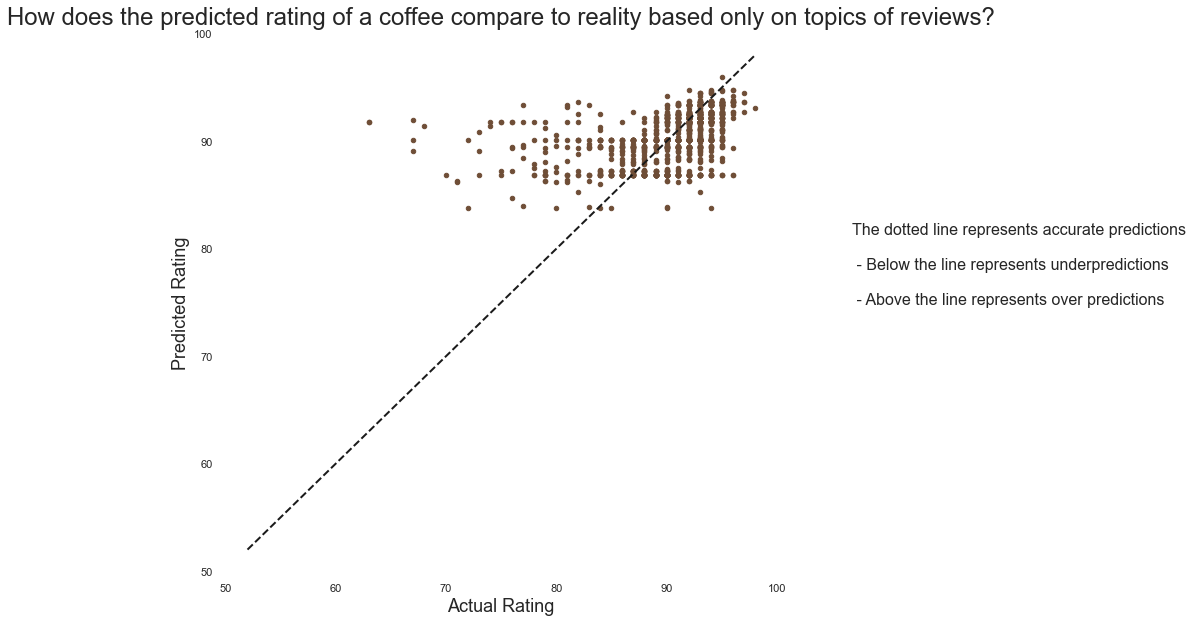

In [136]:
y = one_hot.rating
sns.set(rc={'figure.figsize':(10, 10)})
fig, ax = plt.subplots()
ax.scatter(y_, word_lasso_pred, s=20,color='#6f4e37')
ax.set_facecolor('white')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Actual Rating',fontsize=18)
ax.set_ylabel('Predicted Rating',fontsize=18)
ax.set_title('How does the predicted rating of a coffee compare to reality based only on topics of reviews?',fontsize=24)
txt = 'The dotted line represents accurate predictions' + '\n \n'+' - Below the line represents underpredictions' + '\n\n'+ ' - Above the line represents over predictions'
text = fig.text(1,.5,txt,fontsize=16)
# fig.savefig('OneDrive\Desktop\Metis\Projects\Project 2\wridge_actualvspredicted',kind='png')
plt.show()

In [143]:
# Can I look at which topics appear in the errors most often and surmise they are hurting predictions? Not good topics?
word_errors = pd.concat([pd.DataFrame(y_),pd.DataFrame(X_)],axis=1)
word_errors['preds'] = lasso_words.predict(word_errors.drop(columns='rating'))
word_errors['error'] = np.absolute(word_errors.rating-word_errors.preds)
word_errors.sort_values(by='error',ascending=False).head(100).mean()

rating           79.580000
Two Topic_0       0.240000
Two Topic_1       0.760000
Three Topic_0     0.250000
Three Topic_1     0.540000
Three Topic_2     0.210000
Four Topic_0      0.170000
Four Topic_1      0.470000
Four Topic_2      0.180000
Four Topic_3      0.180000
Five Topic_0      0.060000
Five Topic_1      0.390000
Five Topic_2      0.160000
Five Topic_3      0.220000
Five Topic_4      0.170000
Six Topic_0       0.030000
Six Topic_1       0.360000
Six Topic_2       0.100000
Six Topic_3       0.170000
Six Topic_4       0.190000
Six Topic_5       0.150000
Seven Topic_0     0.020000
Seven Topic_1     0.350000
Seven Topic_2     0.100000
Seven Topic_3     0.090000
Seven Topic_4     0.160000
Seven Topic_5     0.150000
Seven Topic_6     0.130000
Eight Topic_0     0.000000
Eight Topic_1     0.140000
Eight Topic_2     0.040000
Eight Topic_3     0.070000
Eight Topic_4     0.140000
Eight Topic_5     0.080000
Eight Topic_6     0.030000
Eight Topic_7     0.500000
Nine Topic_0      0.000000
N

In [128]:
# kf = KFold(n_splits=5, shuffle=True, random_state = 42)
# cv_lm_poly_r2s = []
# train_X, train_y = np.array(_X), np.array(_y)
# for train_ind, val_ind in kf.split(train_X, train_y):    
    
#     tr_X, tr_y = train_X[train_ind], train_y[train_ind]
#     X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
#     #poly with degree 2
#     poly = PolynomialFeatures(degree=2,interaction_only=True)

#     X_train_poly = poly.fit_transform(tr_X)
#     X_val_poly = poly.transform(X_val)

#     lm_poly = LinearRegression()
    
#     lm_poly.fit(X_train_poly, tr_y)
#     cv_lm_poly_r2s.append(round(lm_poly.score(X_val_poly, y_val), 3))
    
# print('Poly scores: ', cv_lm_poly_r2s, '\n')

# print(f'Poly mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}')

# alphavec = 10**np.linspace(-2,2,200)
# std_poly = StandardScaler()
# std_poly.fit(X_train_poly)
# X_polylasso = std_poly.transform(X_train_poly)

# lasso_poly =  LassoCV(alphas = alphavec, cv = 5)
# lasso_poly.fit(X_train_poly,tr_y)
# list(zip(poly.get_feature_names(_X.columns), lasso_poly.coef_))